In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
  
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [ ]:
import numpy as np
import os
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import skimage.io
import pandas as pd
import skimage.io

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
data, attrs = fetch_dataset()

In [ ]:
x_train, x_val, smile_train, smile_val = train_test_split(data, attrs, test_size=0.9, shuffle=False)

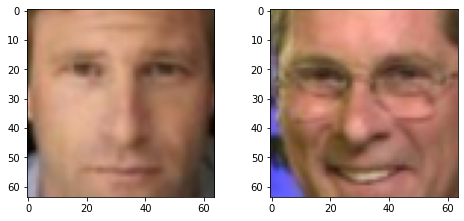

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 20))
for i, (train, val) in enumerate(zip(x_train, x_val)):
  plt.subplot(5, 2, 2*i+1)
  plt.imshow(train)
  plt.subplot(5, 2, 2*i+2)
  plt.imshow(val)
  break

In [ ]:
from torch.utils.data import DataLoader
import numpy as np
x_train = np.array(x_train, np.float32)
x_val = np.array(x_val, np.float32)
batch_size = 32 
data_tr = DataLoader(list(np.rollaxis(x_train, 3,  1)), 
                     batch_size=batch_size, shuffle=True)
#x_train = np.rollaxis(x_train, 3, 1)
#x_val = np.rollaxis(x_val, 3, 1)
data_val = DataLoader(list(np.rollaxis(x_val, 3, 1)),
                      batch_size=batch_size, shuffle=True)

In [ ]:
dim_code = 256 

In [ ]:
from copy import deepcopy

class Autoencoder(torch.nn.Module):
    def __init__(self):
      super().__init__()
      self.encoder = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1), #[32, 16, 64, 64]
          nn.ReLU(),
          nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1), #[32, 32, 64, 64]
          nn.ReLU(),
          nn.Flatten(), #torch.Size([32, 131072])
          nn.Linear(in_features = 131072, out_features=512),  #torch.Size([32, 512])
          nn.ReLU(),
          nn.Linear(in_features=512, out_features=dim_code),  #torch.Size([32, 256])
          nn.ReLU()
      )
      self.decoder = nn.Sequential(
          nn.Linear(in_features = dim_code, out_features=512),
          nn.ReLU(),
          nn.Linear(in_features=512, out_features=131072),
          nn.ReLU(),
          nn.Unflatten(1, [32, 64, 64]),
          nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, padding=1),
      )
          
    def forward(self, x):
        latent = self.encoder(x)
        #print("x shape in forward: ", latent.shape)
        reconstructed = self.decoder(latent)
        #print("reconstruction shape in forward: ", reconstruction.shape)
        return reconstructed, latent



In [ ]:
criterion = F.mse_loss

autoencoder = Autoencoder()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

In [ ]:
n_epochs = 50
train_losses = []
val_losses = []
import torch
device = 'cuda:0'
autoencoder.to(device)
for epoch in (range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    print('* Epoch %d/%d' % (epoch+1, n_epochs))
    for batch in data_tr:
        #print("Training input shape: ", batch.shape)
        optimizer.zero_grad()
        reconstruction, latent = autoencoder(batch.to(device))
        reconstruction = reconstruction.view(-1, 3, 64, 64)
        #print("reconstruction shape after view: ", reconstruction.shape)
        #print("batch.to(device).float(): ", batch.to(device).float().shape)
        loss = criterion(batch.to(device).float(), reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())
        
    train_losses.append(np.mean(train_losses_per_epoch))
    print('loss: %f' % train_losses[epoch])

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in data_val:
          #print(batch.shape)
          reconstruction, latent = autoencoder(batch.to(device))
          #reconstruction = reconstruction.view(-1, 64, 3, 64)
          #print("reconstruction shape after view: ", reconstruction.shape)
          #print("criterion(batch.to(device).float(): ", reconstruction.shape)
          loss = criterion(batch.to(device).float(), reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))
    print('val_loss: %f' % val_losses_per_epoch[epoch])

* Epoch 1/50
loss: 0.046805
val_loss: 0.020984
* Epoch 2/50
loss: 0.021015
val_loss: 0.019392
* Epoch 3/50
loss: 0.016238
val_loss: 0.011994
* Epoch 4/50
loss: 0.013655
val_loss: 0.011802
* Epoch 5/50
loss: 0.012942
val_loss: 0.011140
* Epoch 6/50
loss: 0.012206
val_loss: 0.012448
* Epoch 7/50
loss: 0.011189
val_loss: 0.010671
* Epoch 8/50
loss: 0.010600
val_loss: 0.010600
* Epoch 9/50
loss: 0.009473
val_loss: 0.010181
* Epoch 10/50
loss: 0.008910
val_loss: 0.009112
* Epoch 11/50
loss: 0.008392
val_loss: 0.010980
* Epoch 12/50
loss: 0.007939
val_loss: 0.010622
* Epoch 13/50
loss: 0.007839
val_loss: 0.007820
* Epoch 14/50
loss: 0.007562
val_loss: 0.009568
* Epoch 15/50
loss: 0.007282
val_loss: 0.009618
* Epoch 16/50
loss: 0.007128
val_loss: 0.007629
* Epoch 17/50
loss: 0.006928
val_loss: 0.008741
* Epoch 18/50
loss: 0.006700
val_loss: 0.009140
* Epoch 19/50
loss: 0.006576
val_loss: 0.009628
* Epoch 20/50
loss: 0.006604
val_loss: 0.007520
* Epoch 21/50
loss: 0.005988
val_loss: 0.006890
*

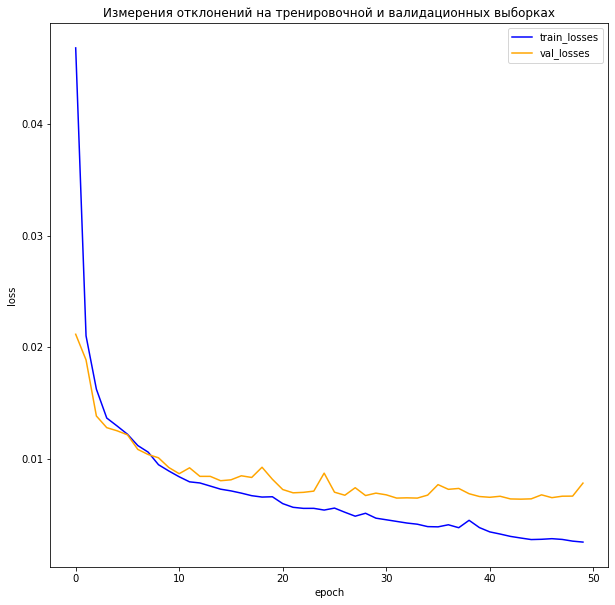

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.plot(list(range(n_epochs)), train_losses, color='blue', label='train_losses')
plt.plot(list(range(n_epochs)), val_losses, color='orange', label='val_losses')
plt.title('Измерения отклонений на тренировочной и валидационных выборках')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

In [ ]:
  autoencoder.eval()
  with torch.no_grad():
      for batch in data_val:
        reconstruction, latent_code = autoencoder(batch.to(device))
        #print(reconstruction.shape)
        reconstruction = reconstruction.view(-1, 3, 64, 64)
        #print(reconstruction.shape)
        result = reconstruction.cpu().detach().numpy()
        #print(result.shape)
        ground_truth = batch.numpy()
        break


torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
(32, 3, 64, 64)


Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


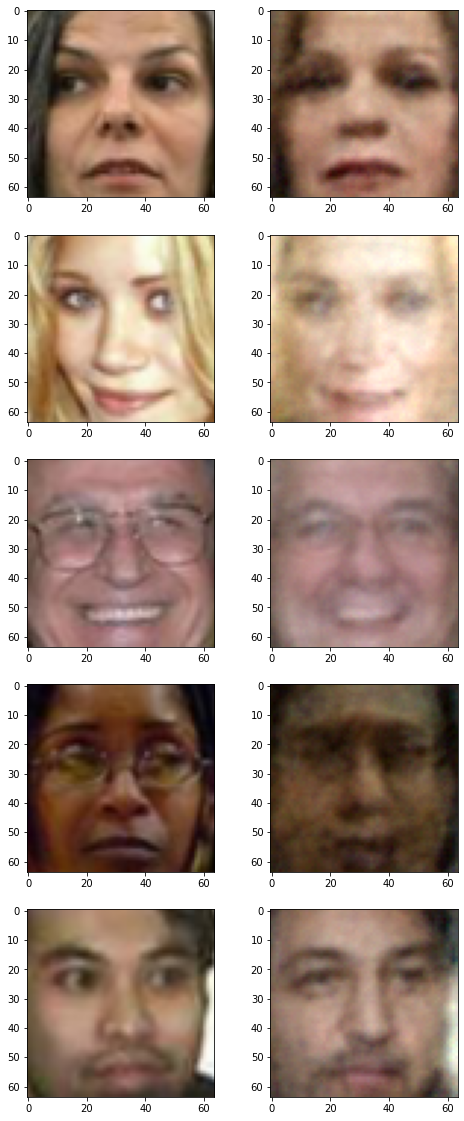

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(5, 2, 2*i+1)
  #print(gt.shape)
  #gt = np.rollaxis(gt, 2,  1)
  #print(gt.shape)
  gt = np.rollaxis(gt, 1, 0)
  gt = np.rollaxis(gt, 2, 1)
  plt.imshow(gt)
  plt.subplot(5, 2, 2*i+2)
  res = np.rollaxis(res, 1, 0)
  res = np.rollaxis(res, 2, 1)
  plt.imshow(res)
  #print(res.shape)

In [ ]:
#усреднение 
for batch in data_tr:
  batch = batch.to(device)
  vector, lat = autoencoder(batch)
  break
lat = lat.to('cpu')
lat = lat.detach().numpy()  
lat_mid = lat.mean(axis=0)   
#стандартное отклонение
lat_st = np.std(lat, axis=0)

In [ ]:
#норм распределение 
norm_rasp = np.random.randn(25, dim_code).astype('float32')

In [ ]:
ans = lat_mid * norm_rasp + lat_st
ans = torch.from_numpy(ans)
ans = ans.to(device)
ans = autoencoder.decoder(ans)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

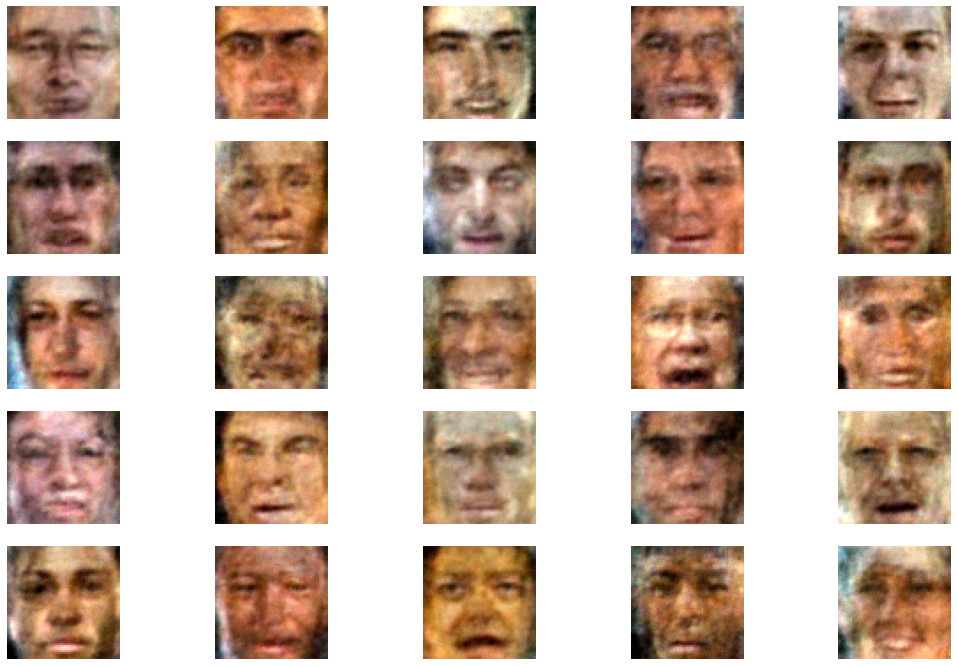

In [ ]:
#norm_rasp = np.random.randn(25, dim_code).astype('float32')
#ans = lat_mid * norm_rasp + lat_st
#ans = torch.from_numpy(ans)
#ans = ans.to(device)
#ans = autoencoder.decoder(ans)
plt.figure(figsize=(18, 12))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.axis("off")
  ans = ans.to('cpu')
  answer = ans.detach()
  answer = np.rollaxis(np.array(answer[i]), 1, 0)
  answer = np.rollaxis(answer, 2, 1)
  plt.imshow(answer)

In [ ]:
Нарусем людям улыбочки:

**Нарусем людям улыбочки:**

In [ ]:
smile = []
sad = []
sad_count = smile_count = 0;
for i in range(1313):
  if (smile_train['Smiling'][i] > 1.5 and smile_count != 15):
    smile.append(i)
    smile_count += 1
  elif smile_train['Smiling'][i] < -1.5 and sad_count != 15:
    sad.append(i)
    sad_count += 1
print(sad)
print(smile)




[49, 53, 56, 62, 63, 71, 74, 75, 81, 82, 107, 117, 120, 123, 128]
[26, 88, 106, 108, 135, 136, 137, 138, 146, 158, 159, 219, 220, 237, 253]


In [ ]:
smiling = []
for i in smile:
  smiling.append(x_train[i])
smiling = torch.Tensor(smiling) 
sadly = []
for i in sad:
  sadly.append(x_train[i])
sadly = torch.Tensor(sadly) 


In [ ]:
sadly = sadly.to(device)
smiling = smiling.to(device)
sadly = sadly.to('cpu')
sadly = sadly.numpy()
sadly = np.rollaxis(sadly, 3, 1)
sadly = torch.from_numpy(sadly)
sadly = sadly.to('cuda')
smiling = smiling.to(device)
smiling = smiling.to('cpu')
smiling = smiling.numpy()
smiling = np.rollaxis(smiling, 3, 1)
smiling = torch.from_numpy(smiling)
smiling = smiling.to('cuda')
sad_after_ae, lat_sad = autoencoder(sadly)
sad_after_ae, lat_sm = autoencoder(smiling)

In [ ]:
   #стандартное отклонение
smile_mid = lat_sm.mean(axis=0)  
sad_mid = lat_sad.mean(axis=0)  
smilling = smile_mid - sad_mid
answer_smile = lat_sad + smilling
answer_smile_sad = autoencoder.decoder(answer_smile)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

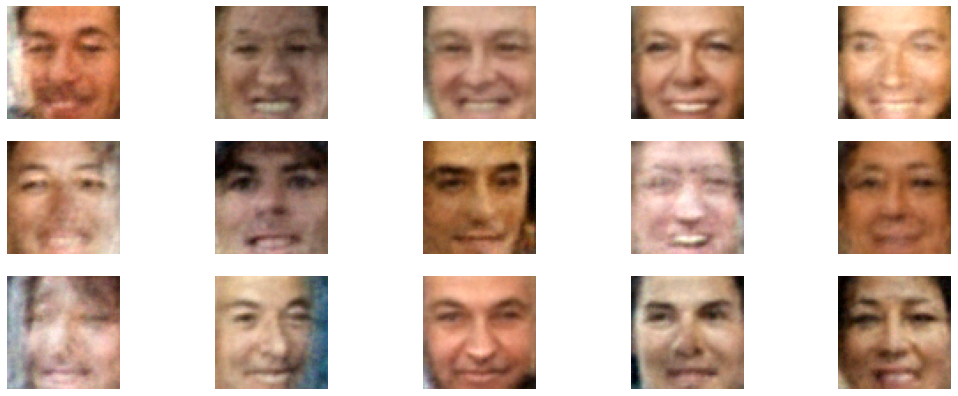

In [ ]:
#(print(answer_smile_sad.shape))
answer_smile_sad1 = answer_smile_sad.to('cpu')
#(print(answer_smile_sad1.shape))
#answer_smile_sad = torch.from_numpy(answer_smile_sad)
plt.figure(figsize=(18, 12))
for i in range(15):
  plt.subplot(5, 5, i+1)
  plt.axis("off")
  #print(answer_smile_sad1[i].shape)
  answer_s = np.rollaxis((answer_smile_sad1[i]).detach().numpy(), 1, 0)
  answer_s = np.rollaxis(answer_s, 2, 1)
  plt.imshow(answer_s)

**СРАВНИМ**

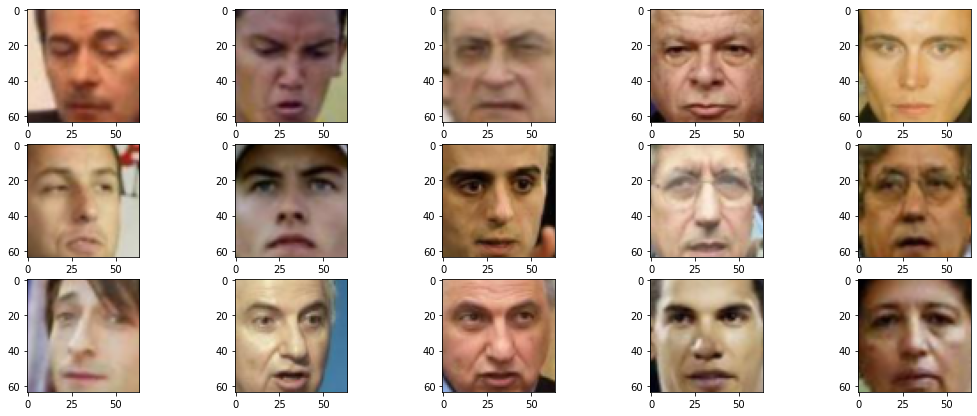

In [ ]:
plt.figure(figsize=(18, 12))
for i in range(15):
  plt.subplot(5, 5, i+1)
  plt.imshow(x_train[sad[i]])